<a href="https://colab.research.google.com/github/acabedo/scripts/blob/main/Speech_corpora_automatic_transcription_and_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is a very basic pipeline to aid researchers with speech oral corpora common operations, like transcription and word/phoneme alignment; the aim is to offer an automatic approach. 

The used scripts are open source and are available at Github; so, all the credits must go to OpenAI (Radford, A., Kim, J. W., Xu, T., Brockman, G., McLeavey, C., & Sutskever, I., developers of **Whisper**), McAuliffe, M., Socolof, M., Mihuc, S., Wagner, M., Sonderegger, M. (developers of **Montreal Forced Aligner**) and Parisse, C., Etienne, C., & Liégeois, L. (developers of **TEICORPO**).

Pease, cite them to credit their work:

1. Radford, A., Kim, J. W., Xu, T., Brockman, G., McLeavey, C., & Sutskever, I. (2022). Robust Speech Recognition via Large-Scale Weak Supervision. arXiv. https://doi.org/10.48550/ARXIV.2212.04356
2. McAuliffe, M., Socolof, M., Mihuc, S., Wagner, M., Sonderegger, M. (2017) Montreal Forced Aligner: Trainable Text-Speech Alignment Using Kaldi. Proc. Interspeech 2017, 498-502, doi: https://doi.org/10.21437/Interspeech.2017-1386
3. Parisse, C., Etienne, C., & Liégeois, L. (2020). TEICORPO: A Conversion Tool for Spoken Language Transcription with a Pivot File in TEI. Journal of the Text Encoding Initiative. https://doi.org/10.4000/jtei.3464

If you want to cite this Google Colab, cite it this way:

Cabedo Nebot, Adrián (2023): Speech corpora automatic transcription and alignment (Google Colab). Available at: https://github.com/acabedo/scripts/blob/main/Speech_corpora_automatic_transcription_and_alignment.ipynb 

Date: 2023, February 13th


# First step: create folders

This google colab environment is designed to create an *input* and an *output* folder and to upload directly your audio files to *input*. If you want to connect your Google Drive, you will need to slightly modify the code below. The folders will appear on the left section when you press the update button (the one folder with a circular line on it).

**Important note:** A google colab like this is not a continuous environment; it means that the files uploaded and folders created will be erased after some transcurring time (depending on your Google colab subscription: free to colab+). So, after transcribing and aligning a file, the main recommendation is to download the files generated at output folder.

In [ ]:
!mkdir input output output/whisper_output output/textgrids

# Second step: download libraries and dependencies

The code below will download Whisper and dependencies

In [ ]:
!pip install git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg


And the following one will install Montreal Forced Aligner and dependencies:

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -n aligner -c conda-forge montreal-forced-aligner

# Third step: transcribe (Whisper)

**Input**: To begin the transcription process, you need to upload an audio file (mp3 or wav) to the *input* folder. If you grant access to your Google Drive, you can simply modify the code below within the quotation marks. For example, "content/drive/MyDrive/wherevertheaudiosare/". If you do the same for the output folder, you won't need to download the files mentioned in the First Step Section.

A good thing about using Whisper is that the output format is customizable. You can select srt, vtt, txt, json and tsv or to get all of of them (this is the default behaviour). The main concern to talk about is that, at this moment, the output is only one speaker tier; in plain English, there is no diarization or speaker differentiation at the output. This is a problem for conversational analysis.

To my current knowledge, there are options to get information about different speakers on a row. One of them tries to get to acoustic differences, like pyannote (https://github.com/pyannote/pyannote-audio) or this script https://huggingface.co/spaces/vumichien/whisper-speaker-diarization). If you work with interviews, one approach could be also to assign questions to one speaker and the other speech units to another speaker; this is not accountable for conversations or less structured talks (conversations, TV debates...).

As you can see in the code below, we are using the large-v2 model. This model is simply the best for Whisper, achieving a low 4% error rate for Spanish, for example. However, it requires more resources. Therefore, my advice is to try other models, such as small or medium, and see how they perform.



In [ ]:
!whisper "/content/input/"*.wav --output_dir "/content/output/whisper_output"  --language Spanish --model large-v2

2023-03-12 07:28:23.476399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 07:28:23.631086: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-12 07:28:24.402067: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64-nvidia
2023-03-12 07:28:24.402156: W tensorflow/compiler/xla/

# Fourth step: convert the srt files to textgrid

To convert srt files to textgrids, you'll need to specify the location of the textgrid folder and the desired output folder. It's worth noting that sometimes, there can be slight timing discrepancies in the conversion process that may cause a slight delay in alignment with the Montreal Forced Alignment tool. Therefore, it's highly recommended that you review the generated Textgrids carefully before proceeding with any further transformations.

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
!wget http://ct3.ortolang.fr/tei-corpo/teicorpo.jar

In [ ]:
!java -cp /content/teicorpo.jar fr.ortolang.teicorpo.TeiCorpo -from srt -to praat -i /content/output/whisper_output -o /content/input 

# Fifth step: align your transcriptions and save the textgrids

This is probably the most difficult parte of the script. It creates a specific user (I call it usertest, but you can name it whatever you like). You will be asked for a password, a repeat password question and after that some metadata (Full Name, Room Number..); these metadata can be override just by clicking enter.

In [ ]:
!adduser usertest 

The code below will be give the user created the rights to write files to output/textgrids folder.

In [ ]:
!usermod -aG sudo usertest
!sudo chown -R usertest:usertest /content/output/textgrids


Finally, if you execute the next code, you will be able to access to a password box style. In that box you have to copy this (as it is disposed below, incuding semicolons):

source activate aligner; mfa model download dictionary spanish_spain_mfa; mfa model download acoustic spanish_mfa; mfa server start; mfa align --clean ./input spanish_spain_mfa spanish_mfa ./output/textgrids



In [ ]:
!su usertest 



# Expected result

The textgrid that we want to get is something similar to this screenshot:


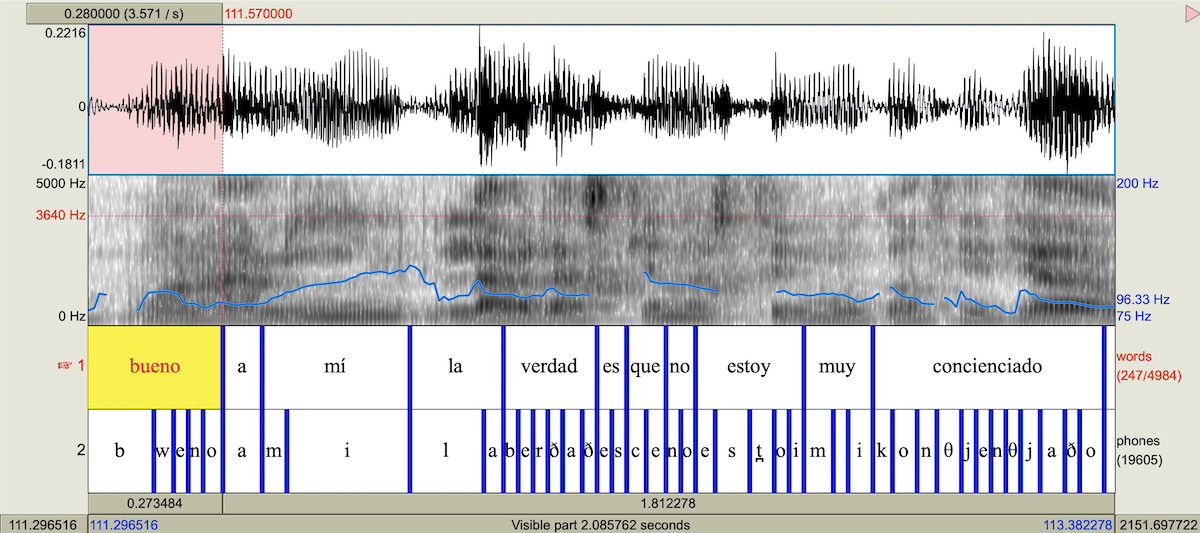


# License



MIT License

Copyright (c) 2023 Adrián Cabedo Nebot

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.